# Objectives: 
## - Develop a predictive (regression) model that predicts prices of (future) iPhone releases
## - Train the model with data of iPhone prices from first release (2007) to present day
## - Deploy predictive model into the front-end as a web application using Dash (Python) and/or React (JavaScript) 


In [264]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import seaborn as sns 
%matplotlib inline 

data_path = "./iphone_releases.csv"

iphones = pd.read_csv(data_path)

def saveOutput(df, filename):
    df.to_csv(filename)

### Stage 1: Pre-Processing
#### - Clean, format, and repurpose iPhone price data for the predictive model

In [265]:
## DATA CLEANING AND REFORMATTING 

# CONVERT ALL TO LOWERCASE 
# turn rows to uppercase 
iphones = iphones.apply(lambda col: col.str.upper() if 'O' == col.dtype  else col) 
# turn columns to uppercase 
iphones.columns = iphones.columns.str.upper() 

# REFORMAT "DATE" COLUMN 
# exclude month and day, only keep year 
iphones["DATE"] = iphones["DATE"].str[:4] 

# RENAME COLUMNS 
# rename "date" column to "year" 
iphones.rename(columns={"DATE": "YEAR"}, inplace=True) 
# rename "memory" column to "GB" 
iphones.rename(columns={"MEMORY": "GB"}, inplace=True) 

# FILL MISSING VALUES 
# set the "version" of the first 2 rows (original iPhone) as "1" 
iphones.loc[2007 == iphones["YEAR"].astype(int) , "VERSION"] = 1 

# set missing "edition" values to 0, for iPhones not of special edition 
edition_regular = "STANDARD" 
iphones.loc[iphones["EDITION"].isnull(), "EDITION"] = edition_regular 

# set missing "scale" values to "STANDARD", for iPhones not of special size 
size_regular = "MEDIUM" 
iphones.loc[iphones["SCALE"].isnull(), "SCALE"] = size_regular 

# RE-FORMAT SIMILAR (REDUNDANT) VALUE TYPES 
# reformat "edition" column, merge "S" and "PRO" values 
edition_special = "SPECIAL" 
iphones.loc[('S' == iphones["EDITION"]) | ("PRO" == iphones["EDITION"]), "EDITION"] = edition_special 

# reformat "scale" column, merge "Plus" and "Max" values 
size_large = "LARGE" 
iphones.loc[("PLUS" == iphones["SCALE"]) | ("MAX" == iphones["SCALE"]), "SCALE"] = size_large 

# REMOVE OUTLIERS / EXCEPTIONAL DATA POINTS 
# drop samples with "edition" values other than "SPECIAL" or "STANDARD" (like "R" or "C") 
iphones = iphones.loc[~((iphones["EDITION"] != edition_regular) & (iphones["EDITION"] != edition_special))] 

# drop samples with "edition" values other than "NORMAL" or "LARGE" (like "MINI") 
iphones = iphones.loc[~((iphones["SCALE"] != size_regular) & (iphones["SCALE"] != size_large))] 

# drop releases from 2007 due to unusual prices 
iphones = iphones.loc[~(2007 == iphones["YEAR"].astype(int))] 

In [266]:
## DATA ENGINEERING (REPURPOSING) 

# convert "EDITION" to binary feature (via casting) 
iphones.loc[:, "EDITION"] = (edition_special == iphones["EDITION"]).astype(int) 
# rename "EDITION" column  to "SPECIAL" 
iphones.rename(columns={"EDITION": "SPECIAL"}, inplace=True) 

# convert "SCALE" to binary feature (via casting) 
iphones.loc[:, "SCALE"] = (size_large == iphones["SCALE"]).astype(int) 
# rename "SCALE" column to "LARGE" 
iphones.rename(columns={"SCALE": "LARGE"}, inplace=True) 

### Stage 2: EDA (Exploratory Data Analysis) 

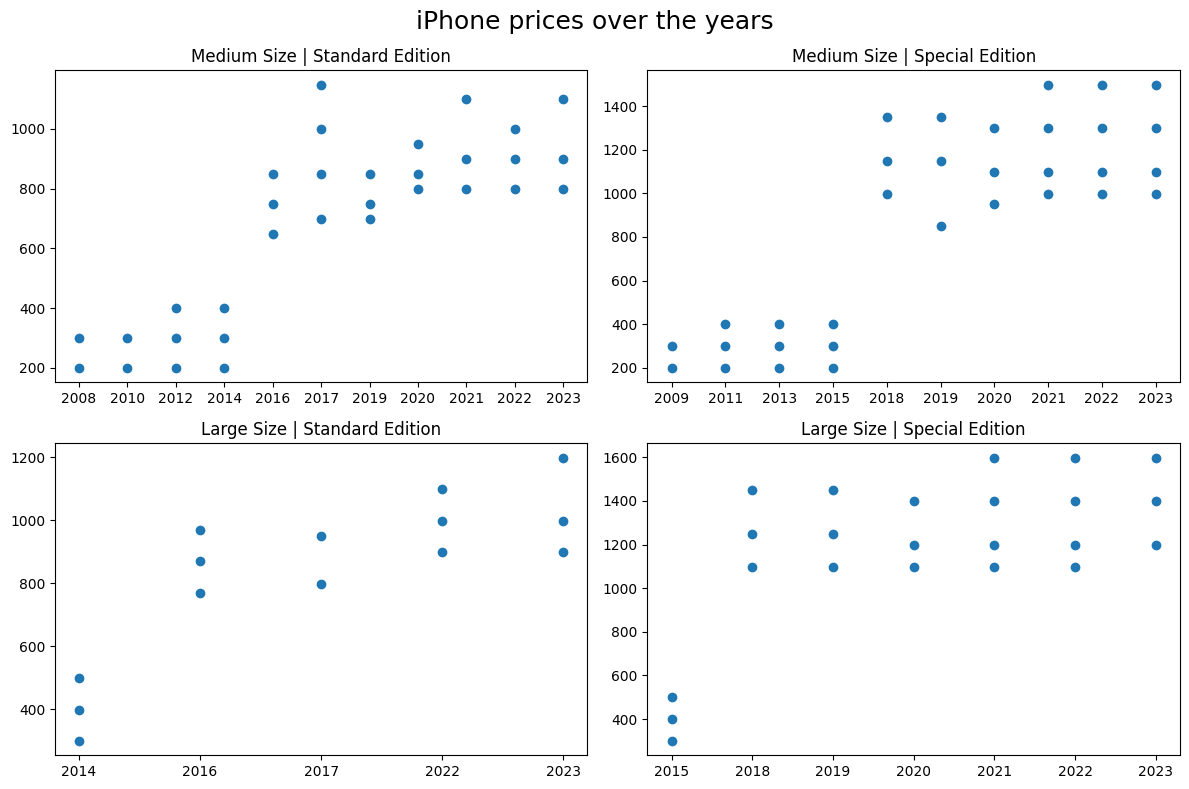

In [267]:
## DATA VISUALIZATION OF PRICES BY CATEGORY 

# PLOT AVERAGE PRICES OF IPHONE EDITIONS OVER THE YEARS 
# DIVIDE INTO CATEGORIES OF SIZE AND EDITION 

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8)) 
fig.suptitle("iPhone prices over the years", size=18) 

# plot medium-sized, standard edition iPhones 
axes[0,0].set_title("Medium Size | Standard Edition") 
phones_med_std = iphones.loc[(0 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])] 
axes[0,0].scatter(phones_med_std["YEAR"], phones_med_std["PRICE"])

# plot medium-sized, special edition iPhones 
axes[0,1].set_title("Medium Size | Special Edition") 
phones_med_spec = iphones.loc[(0 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[0,1].scatter(phones_med_spec["YEAR"], phones_med_spec["PRICE"]) 

# plot large-sized, standard edition iPhones 
axes[1,0].set_title("Large Size | Standard Edition") 
phones_lg_std = iphones.loc[(1 == iphones["LARGE"]) & (0 == iphones["SPECIAL"])]
axes[1,0].scatter(phones_lg_std["YEAR"], phones_lg_std["PRICE"])

# plot large-sized, special edition iPhones 
axes[1,1].set_title("Large Size | Special Edition") 
phones_lg_spec = iphones.loc[(1 == iphones["LARGE"]) & (1 == iphones["SPECIAL"])] 
axes[1,1].scatter(phones_lg_spec["YEAR"], phones_lg_spec["PRICE"]) 

fig.tight_layout() 

# WE OBSERVE A SIGNIFICANT PRICE INCREASE IN ALL CATEGORIES BETWEEN 2016 AND 2018 

In [268]:
## DATA VISUALIZATION OF PRICES BY STORAGE CAPACITY

In [269]:
# ## **EXPERIMENTAL** 
# # GET DUMMIES FOR DIFFERENT STORAGE CAPACITY VALUES 
# # although numerical, gigabyte capacities come in fixed (non-continuous) values (powers of 2) and don't seem to linearly affect the price 
# # essentially, they are more categorical in nature, and only represented numerically 
# iphones = pd.concat( 
#     [
#         iphones, 
#         pd.get_dummies( 
#             iphones["GB"], 
#             prefix="GB", 
#             drop_first=True 
#         ).astype(int) 
#     ], 
#     axis=1 
# ) 
# # drop "GB" column 
# iphones.drop(["GB"], axis=1, inplace=True) 

In [270]:
saveOutput(iphones, "iphones_output.csv")

iphones

,YEAR,VERSION,SPECIAL,LARGE,GB,PRICE
2,2008,3G,0,0,8,199.0
3,2008,3G,0,0,16,299.0
4,2009,3G,1,0,16,199.0
5,2009,3G,1,0,32,299.0
6,2010,4,0,0,16,199.0
...,...,...,...,...,...,...
109,2023,15,1,0,512,1299.0
110,2023,15,1,0,1024,1499.0
111,2023,15,1,1,256,1199.0
112,2023,15,1,1,512,1399.0
